In [1]:
import copy

from catboost import CatBoostClassifier
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdFingerprintGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader as GraphDataLoader
from sklearn.metrics import mean_squared_error

import src.utils as utils
from src.dataset import (
    create_synthetic_target,
    create_synthetic_dataset,
    load_cyp_data_split,
    load_herg_data_split,
    load_synthetic_data_split
)
from src.featurizers import ECFPFeaturizer, GraphFeaturizer
from src.splitters import ScaffoldSplitter
from src.models.gnn import GraphConvolutionalNetwork
from src.early_stopping import EarlyStopping
from src.explanations import (
    abs_feature_importance_and_lime_difference,
    get_dataframe_from_lime_results,
    get_connected_components_for_explanation,
    generate_lime_explanations,
    plot_grad_cam_explanation,
    plot_saliency_map_explanation,
    saliency_map,
    grad_cam
)
from src.utils import get_morgan_fragment, load_gnn_model, load_catboost_model, draw_morgan_bit, draw_many_morgan_bits
from tuning_results import synthetic_catboost_params, herg_catboost_params, cyp_catboost_params

seed = 1
np.random.seed(seed)

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\kamil\miniconda3\envs\masters\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [4]:
train, _, test = load_synthetic_data_split()

fp_size = 2048
fp_radius = 2
featurizer = ECFPFeaturizer("y", length=fp_size, radius=fp_radius, log_target_transform=False)
X_train, y_train = featurizer(train)
X_test, y_test = featurizer(test)

### Testing LIME on synthetic data

In [3]:
model = CatBoostClassifier(
    iterations=9999,
    learning_rate=synthetic_catboost_params["lr"],
    max_depth=synthetic_catboost_params["max_depth"],
    l2_leaf_reg=synthetic_catboost_params["l2_leaf_reg"],
)
model = model.load_model("models/catboost_tuned_synthetic.cbm")

In [5]:
mols_to_check = np.random.choice(len(X_test), 5)
X_test_to_check = X_test[mols_to_check]

n_trials = 50
results = []
for trial in range(n_trials):
    results.append(generate_lime_explanations(X_train, model, X_test_to_check))
results = np.array(results)

In [12]:
bits_found_by_lime = set()
for i in range(len(results)):
    for j in range(len(results[i])):
        for k in range(len(results[j])):
            bits_found_by_lime.add(results[i][j][k][0])

bits_found_in_each_mol = []
bits_coefficients = []
for i in range(len(results[0])):
    bits_found_in_each_mol.append(results[:, i, :, 0].flatten())
    bits_coefficients.append(results[:, i, :, 1].flatten())

The top bit (1750), according to feature attribution, is found for each molecule tested. This is promising and warrants testing on real datasets. I suspect, however, that this is due to the fact that the task posed in the synthetic data is easy.

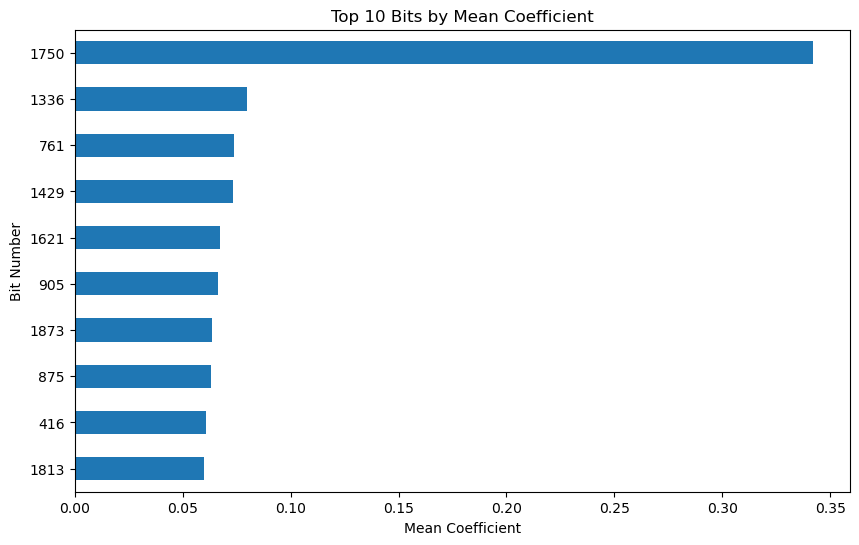

In [67]:
individual_results = []

for i in range(len(bits_found_in_each_mol)):
    lime_results = pd.DataFrame(data={"bit_number": bits_found_in_each_mol[i], "coefficient": bits_coefficients[i]})
    lime_results.loc[:, "bit_number"] = lime_results["bit_number"].astype(int)
    lime_results.loc[:, "coefficient"] = lime_results["coefficient"].astype(float)
    lime_results = lime_results.assign(mean=lime_results.groupby("bit_number")["coefficient"].transform("mean"))
    individual_results.append(lime_results)
aggregated_mean_lime_coef = pd.concat(individual_results)

top_10_bits = aggregated_mean_lime_coef.groupby("bit_number")["coefficient"].mean().sort_values(ascending=False).head(10)
top_10_bits.index = top_10_bits.index.astype("object")

plt.figure(figsize=(10, 6))
top_10_bits.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Bits by Mean Coefficient')
plt.xlabel('Mean Coefficient')
plt.ylabel('Bit Number')
plt.show()

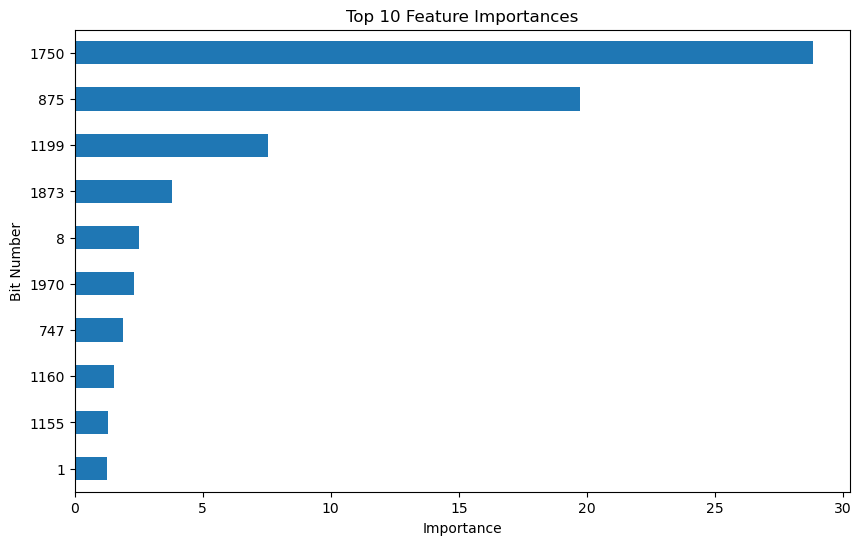

In [68]:
feature_importances = model.get_feature_importance(prettified=True).head(10)
feature_importances = feature_importances.rename(columns={"Feature Id": "bit_number", "Importances": "importance"})

plt.figure(figsize=(10, 6))
feature_importances.set_index('bit_number')['importance'].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Bit Number')
plt.show()

In [ ]:
abs_feature_importance_and_lime_difference(feature_importances, top_10_bits)

0.261487887783807

### Testing LIME on real datasets

We will approximate the global effect of bits by sampling a set number of molecules, running LIME on each of them, and averaging the results. Then, we will compare said results to feature importance scores.

In [2]:
def run_lime_on_n_random_molecules(train_data, test_data, model, n_molecules: int = 50):
    X_train, _ = featurizer(train_data)
    X_test, _ = featurizer(test_data)
    test_molecules_to_check = X_test[np.random.choice(len(X_test), n_molecules)]
    lime_results = get_dataframe_from_lime_results(generate_lime_explanations(X_train, model, test_molecules_to_check))
    return lime_results


def test_lime_vs_feature_importance(lime_results, model):
    top_10_lime_bits = lime_results.groupby("bit_number")["coefficient"].mean().sort_values(ascending=False).head(10)
    feature_importances = model.get_feature_importance(prettified=True).head(10)
    feature_importances = feature_importances.rename(columns={"Feature Id": "bit_number", "Importances": "importance"})
    return abs_feature_importance_and_lime_difference(feature_importances, top_10_lime_bits)

In [21]:
# best_params = cyp_catboost_params
# dataset_name = "cyp"
# cyp_model = load_catboost_model(dataset_name, best_params)
# cyp_train, _, cyp_test = load_cyp_data_split()
# cyp_lime_results = run_lime_on_n_random_molecules(cyp_train, cyp_test, cyp_model)
# cyp_result = test_lime_vs_feature_importance(cyp_lime_results, cyp_model)

best_params = herg_catboost_params
dataset_name = "herg"
herg_model = load_catboost_model(dataset_name, best_params)
herg_train, _, herg_test = load_herg_data_split()
herg_lime_results = run_lime_on_n_random_molecules(herg_train, herg_test, herg_model)
herg_result = test_lime_vs_feature_importance(herg_lime_results, herg_model)

# best_params = synthetic_catboost_params
# dataset_name = "synthetic"
# synthetic_model = load_catboost_model(dataset_name, best_params)
# synthetic_train, _, synthetic_test = load_synthetic_data_split()
# synthetic_lime_results = run_lime_on_n_random_molecules(synthetic_train, synthetic_test, synthetic_model)
# synthetic_result = test_lime_vs_feature_importance(synthetic_lime_results, synthetic_model)

Found local copy...
Loading...
Done!
[11:05:54] WARNING: not removing hydrogen atom without neighbors
[11:05:54] WARNING: not removing hydrogen atom without neighbors


In [93]:
np.save(arr=cyp_lime_results, file="results/lime_feature_imp/cyp_lime_results.npy")
np.save(arr=herg_lime_results, file="results/lime_feature_imp/herg_lime_results.npy")
np.save(arr=synthetic_lime_results, file="results/lime_feature_imp/synthetic_lime_results.npy")

Assuming both methods found the same bits, the expected difference is 1/3 if the scores were random.\
Here, the result is higher due to different bits being found, and so in those cases the comparison is between 0 and x, where x is the score for this bit in the other method.\
Anyway, these are poor scores.

In [9]:
herg_result

0.37315615661094204

In [10]:
cyp_result

0.5171477886000302

In [11]:
synthetic_result

0.19227612337989802

Plotting the most important bits

In [81]:
def draw_many_morgan_bits(molecules, bit_ids, radius=2, length=2048):
    results = []
    for bit_id in bit_ids:
        for mol in molecules:
            additional_output = rdFingerprintGenerator.AdditionalOutput()
            additional_output.AllocateBitInfoMap()
            fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=length)
            fp = fp_gen.GetFingerprint(mol, additionalOutput=additional_output)
            if bit_id in additional_output.GetBitInfoMap():
                break
        results.append((mol, bit_id, additional_output.GetBitInfoMap()))
    return Draw.DrawMorganBits(results, molsPerRow=1, legends=None)

In [117]:
def save_bar_plot_of_lime_scores(lime_scores, plot_name, dataset_name):
    lime_scores_asc = lime_scores.sort_values(ascending=True)
    plt.figure(figsize=(12, 8))  # Increase the plot size
    plt.barh(y=list(range(len(lime_scores_asc))), width=lime_scores_asc.values, height=0.6)  # Make bars slightly smaller
    plt.xlabel("Mean LIME Coefficient", fontsize=14)
    plt.xticks(fontsize=12)  # Increase the font size of x-axis values
    plt.title(f"Top 5 {dataset_name} Bits by Mean LIME Coefficient", fontsize=16)
    plt.yticks([])  # Remove y-axis labels
    plt.savefig(f"results/lime_feature_imp/{plot_name}.png")
    plt.close()

In [118]:
herg_top_5_lime_results = herg_lime_results.groupby("bit_number")["coefficient"].mean().sort_values(ascending=False).head(5)
plot = draw_many_morgan_bits(herg_train, herg_top_5_lime_results.index.astype(int))
plot.save("results/lime_feature_imp/herg_top_5_lime_bits.png")
save_bar_plot_of_lime_scores(herg_top_5_lime_results, "bar_plot_herg_top_5_lime_bits", "hERG")

In [119]:
cyp_top_5_lime_results = cyp_lime_results.groupby("bit_number")["coefficient"].mean().sort_values(ascending=False).head(5)
plot = draw_many_morgan_bits(cyp_train, cyp_top_5_lime_results.index.astype(int)[:5])
plot.save("results/lime_feature_imp/cyp_top_5_lime_bits.png")
save_bar_plot_of_lime_scores(cyp_top_5_lime_results, "bar_plot_cyp_top_5_lime_bits", "CYP3A4")

In [120]:
synthetic_top_5_lime_results = synthetic_lime_results.groupby("bit_number")["coefficient"].mean().sort_values(ascending=False).head(5)
plot = draw_many_morgan_bits(synthetic_train, synthetic_top_5_lime_results.index.astype(int)[:5])
plot.save("results/lime_feature_imp/synthetic_top_5_lime_bits.png")
save_bar_plot_of_lime_scores(synthetic_top_5_lime_results, "bar_plot_synthetic_top_5_lime_bits", "Synthetic")

In [121]:
def save_bar_plot_of_feature_importance(feature_importance, plot_name, dataset_name):
    feature_importance_asc = feature_importance.sort_values(ascending=True)
    plt.figure(figsize=(12, 8))  # Increase the plot size
    plt.barh(y=list(range(len(feature_importance_asc))), width=feature_importance_asc.values, height=0.6)
    plt.xlabel("Importance", fontsize=14)
    plt.xticks(fontsize=12)  # Increase the font size of x-axis values
    plt.title(f"Top 5 {dataset_name} Bits by Feature Importance", fontsize=16)
    plt.yticks([])  # Remove y-axis labels
    plt.savefig(f"results/lime_feature_imp/{plot_name}.png")
    plt.close()

In [122]:
herg_top_5_feature_importances = herg_model.get_feature_importance(prettified=True).head(5)
plot = draw_many_morgan_bits(herg_train, herg_top_5_feature_importances["Feature Id"].astype(int))
plot.save("results/lime_feature_imp/herg_top_5_feature_importances.png")
save_bar_plot_of_feature_importance(herg_top_5_feature_importances["Importances"], "bar_plot_herg_top_5_feature_importances", "hERG")

In [123]:
cyp_top_5_feature_importances = cyp_model.get_feature_importance(prettified=True).head(5)
plot = draw_many_morgan_bits(cyp_train, cyp_top_5_feature_importances["Feature Id"].astype(int))
plot.save("results/lime_feature_imp/cyp_top_5_feature_importances.png")
save_bar_plot_of_feature_importance(cyp_top_5_feature_importances["Importances"], "bar_plot_cyp_top_5_feature_importances", "CYP3A4")

In [124]:
synthetic_top_5_feature_importances = synthetic_model.get_feature_importance(prettified=True).head(5)
plot = draw_many_morgan_bits(synthetic_train, synthetic_top_5_feature_importances["Feature Id"].astype(int))
plot.save("results/lime_feature_imp/synthetic_top_5_feature_importances.png")
save_bar_plot_of_feature_importance(synthetic_top_5_feature_importances["Importances"], "bar_plot_synthetic_top_5_feature_importances", "Synthetic")